In [ ]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 6.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook, tqdm
from time import sleep

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1mOEP6woH_9Ox8_Va0V5DibWttYR6u930' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1mOEP6woH_9Ox8_Va0V5DibWttYR6u930" -O train_dataset.zip && rm -rf /tmp/cookies.txt

--2023-10-22 18:39:50--  https://docs.google.com/uc?export=download&confirm=t&id=1mOEP6woH_9Ox8_Va0V5DibWttYR6u930
Resolving docs.google.com (docs.google.com)... 74.125.201.102, 74.125.201.139, 74.125.201.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.201.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-a8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lum09kqoh4tebft7b27trgedh49o100n/1697999925000/12656769980704004828/*/1mOEP6woH_9Ox8_Va0V5DibWttYR6u930?e=download&uuid=e0b609dd-8b4b-45b1-8a91-3904a3cce429 [following]
--2023-10-22 18:39:50--  https://doc-0g-a8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lum09kqoh4tebft7b27trgedh49o100n/1697999925000/12656769980704004828/*/1mOEP6woH_9Ox8_Va0V5DibWttYR6u930?e=download&uuid=e0b609dd-8b4b-45b1-8a91-3904a3cce429
Resolving doc-0g-a8-docs.googleusercontent.com (doc-0g-a8-docs.googleusercontent.com)... 173.194.197.132,

In [ ]:
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1mOEP6woH_9Ox8_Va0V5DibWttYR6u930'

In [ ]:
!unzip train_dataset.zip

Archive:  train_dataset.zip
  inflating: test/images/20200520_194614_01_JPG.rf.608a8b0fb1ef6a00bc4d5cb723386195.jpg  
  inflating: test/images/20200520_194657_01_JPG.rf.9d2f98d60b7d94055523b6e12b39fa10.jpg  
  inflating: test/images/20200520_214839_01_JPG.rf.9b38fd8cf74453b1837052ae1a476078.jpg  
  inflating: test/images/20200521_065125_01_JPG.rf.94e220a6ec114bcc6dcaa6f8a087552f.jpg  
  inflating: test/images/20200521_085200_01_JPG.rf.bc31e4d44d1925899c4be5a2183bba87.jpg  
  inflating: test/images/20200521_165417_01_JPG.rf.8f9738ea14df1bf74a3f9d489f811a0b.jpg  
  inflating: test/images/20200521_185451_01_JPG.rf.ce8bb474653d4a11503c84b341c602bc.jpg  
  inflating: test/images/20200521_195509_01_JPG.rf.6ee8bf041b3178e2174d50d917dcc044.jpg  
  inflating: test/images/20200522_055812_01_JPG.rf.792e8156e38c8c35ad3b629e4c02d5ee.jpg  
  inflating: test/images/20200522_075847_01_JPG.rf.ff82846fbe8a7d7fcfa59fbeb18dd26b.jpg  
  inflating: test/images/20200522_085904_01_JPG.rf.b2f0c7a4c8aab86dc10e7

In [ ]:
import os
from PIL import Image
from PIL.Image import Resampling

class IncreaseResolutionDataset(Dataset):
    def __init__(self, path):
        self.filenames = []
        self.root = path
        for (_, _, files) in os.walk(path):
            for file in files:
                # TODO: Проверять, чтобы картинка была более 1 пикселя...
                # И например, не слишком большой
                self.filenames.append(file)
            break

    def __len__(self):
        return len(self.filenames) # Возвращает количество изображений

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image = Image.open(self.root + filename)

        image_width = image.size[0]
        image_height = image.size[1]
        image_preprocess = lambda lenght: lenght if lenght % 2 == 0 else lenght - 1

        image_preprocessed = image.crop((0, 0, image_preprocess(image_width), image_preprocess(image_height)))

        image_rescaled = image_preprocessed.copy()
        image_rescaled.thumbnail((image_rescaled.size[0] // 2, image_rescaled.size[1] // 2),
                                 resample=Resampling.BICUBIC)

        X = torch.tensor(np.array(image_rescaled, dtype=np.float32)).transpose(1, 2).transpose(0, 1)
        Y = torch.tensor(np.array(image_preprocessed, dtype=np.float32)).transpose(1, 2).transpose(0, 1)

        return X, Y

In [ ]:
dataset = IncreaseResolutionDataset("./train/train/images/")
loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:
dataset[0][0].shape

torch.Size([3, 320, 320])

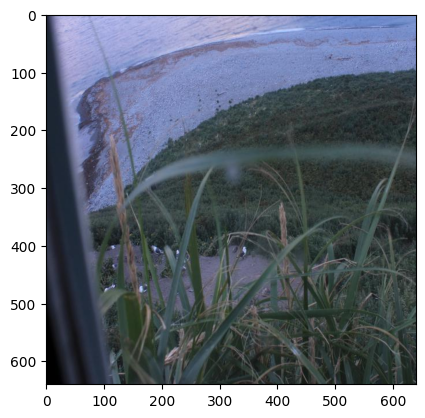

In [ ]:
plt.imshow(Image.fromarray(np.uint8(dataset[0][1].transpose(0, 1).transpose(1, 2))))

In [ ]:
valid_dataset = IncreaseResolutionDataset("./train/valid/images/")
valid_loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:
class Upscaler(nn.Module):
    def BlockUp(self, input, output):
        return nn.Sequential(nn.Conv2d(input, output, (3, 3), padding=1), # по дефолту stride = 1, а следовательно размерность не меняется
                                                                          # меняем мы только количество каналов input на output
                             nn.MaxPool2d((2, 2), stride=(2, 2)), # а вот тут мы уменьшаем и высоту, и ширину, в два раза
                             nn.Sigmoid(),
                             nn.BatchNorm2d(output)) # Нормализуем параметры для быстрого обучения сети


    def BlockDown(self, input, output):
        return nn.Sequential(nn.Upsample(scale_factor=2),
                             nn.Conv2d(input, output, (3, 3), padding=1),
                             nn.Sigmoid(),
                             nn.BatchNorm2d(output))

    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            nn.BatchNorm2d(3),
            self.BlockUp(3, 24),
            self.BlockDown(24, 3),
            nn.Upsample(scale_factor=2),
            nn.Sigmoid()
        )

        self.l1 = nn.BatchNorm2d(3)
        self.l2 = nn.Conv2d(3, 24, (3, 3), padding=1)
        self.l3 = nn.MaxPool2d((2, 2), stride=(2, 2))
        self.l4 = nn.Sigmoid()
        self.l5 = nn.BatchNorm2d(24)
        self.l6 = nn.Upsample(scale_factor=2)
        self.l7 = nn.Conv2d(24, 3, (3, 3), padding=1)
        self.l8 = nn.Sigmoid()
        self.l9 = nn.BatchNorm2d(3)
        self.l10 = nn.Upsample(scale_factor=2)
        self.l11 = nn.Sigmoid()

    def forward(self, x):
        y = self.l1(x)

        y = self.l2(y)
        y = self.l3(y)
        y = self.l4(y)
        y = self.l5(y)

        y = self.l6(y)
        y = self.l7(y)
        y = self.l8(y)
        y = self.l9(y)

        y = self.l10(y)

        return self.l11(y)
        # return self.network(x)

In [ ]:
device = torch.device('cpu')

In [ ]:
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

num_epochs = 25
lr = 0.005

model = Upscaler().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
lpips = LearnedPerceptualImagePatchSimilarity(net_type='squeeze').to(device)

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 22.0MB/s]


In [ ]:
from torch.nn.utils import clip_grad_norm_

history = []
metrics = []
valid_metrics = []
for epoch in tqdm_notebook(range(num_epochs)):
    current_losses = []
    current_metrics = []
    current_valid_metrics = []
    for x, y in loader: # лоадер - генератор, который возвращает каждый раз батч изображений
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad() # обнуляю градиенты

        y_ = model(x) # когда мы пишем model(x), передавая в качестве x - батч из 64 или из любого количества изображений,
                      # мы понимаем, что внутри x размерности [размер_батча, количество каналов, высота, ширина] (64, 3, 128, 128)
                      # подразумевается
                      # output = [model(image) for image in x],
                      # так как наша модель заточена для одной картинки [3, x, y], где 3 - количество каналов, x, y - размеры картинки
                      # то есть для каждого изображения в батче x, мы получаем батч output
                      # это внутри распаралелено для быстрой скорости

        loss = criterion(y / 255, y_) # считаем лосс
        current_losses.append(loss.item())

        metric_value = lpips(y_, y / 255)
        current_metrics.append(metric_value.item())

        loss.backward() # производные

        optimizer.step() # Делаем шаг

        del x
        del y
        del y_
        del loss
        del metric_value

    history.append(np.array(current_losses).mean())
    metrics.append(np.array(current_metrics).mean())

    for x_val, y_val in valid_loader:
        x = x_val.to(device)
        y = y_val.to(device)

        y_ = model(x)

        metric_value = lpips(y / 255, y_)
        current_valid_metrics.append(metric_value.item())

        del x
        del y
        del y_
        del metric_value

    valid_metrics.append(np.array(current_valid_metrics).mean())

<ipython-input-19-791efacb29d7>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(num_epochs)):


  0%|          | 0/25 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
metric_nearest = []
metric_bilinear = []
metric_bicubic = []
metric_lanczos = []

for x, y in tqdm_notebook(loader):
    x = np.uint8(x.transpose(1, 2).transpose(2, 3))

    y_nearest = []
    y_bilinear = []
    y_bicubic = []
    y_lanczos = []

    for item in x:
        image = Image.fromarray(item)
        new_size = (image.size[0] * 2, image.size[1] * 2)

        image_resized_nearest = image.resize(new_size, Image.NEAREST)
        image_resized_bilinear = image.resize(new_size, Image.BILINEAR)
        image_resized_bicubic = image.resize(new_size, Image.BICUBIC)
        image_resized_lanczos = image.resize(new_size, Image.LANCZOS)

        y_nearest.append(np.array(image_resized_nearest))
        y_bilinear.append(np.array(image_resized_bilinear))
        y_bicubic.append(np.array(image_resized_bicubic))
        y_lanczos.append(np.array(image_resized_lanczos))

    y_nearest = torch.tensor(np.array(y_nearest)).transpose(2, 3).transpose(1, 2).to(device)
    y_bilinear = torch.tensor(np.array(y_bilinear)).transpose(2, 3).transpose(1, 2).to(device)
    y_bicubic = torch.tensor(np.array(y_bicubic)).transpose(2, 3).transpose(1, 2).to(device)
    y_lanczos = torch.tensor(np.array(y_lanczos)).transpose(2, 3).transpose(1, 2).to(device)

    y = y.to(device)

    metric_value_resized_nearest = lpips(y_nearest / 255, y / 255)
    metric_value_resized_bilinear = lpips(y_bilinear / 255, y / 255)
    metric_value_resized_bicubic = lpips(y_bicubic / 255, y / 255)
    metric_value_resized_lanczos = lpips(y_lanczos / 255, y / 255)

    metric_nearest.append(metric_value_resized_nearest.item())
    metric_bilinear.append(metric_value_resized_bilinear.item())
    metric_bicubic.append(metric_value_resized_bicubic.item())
    metric_lanczos.append(metric_value_resized_lanczos.item())

    del item
    del image

    del image_resized_nearest
    del image_resized_bilinear
    del image_resized_bicubic
    del image_resized_lanczos

    del y_nearest
    del y_bilinear
    del y_bicubic
    del y_lanczos

    del metric_value_resized_nearest
    del metric_value_resized_bilinear
    del metric_value_resized_bicubic
    del metric_value_resized_lanczos

    del y

<ipython-input-60-f266e317aed8>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x, y in tqdm_notebook(loader):


  0%|          | 0/63 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Metrics (LPIPS): Valid vs resize')

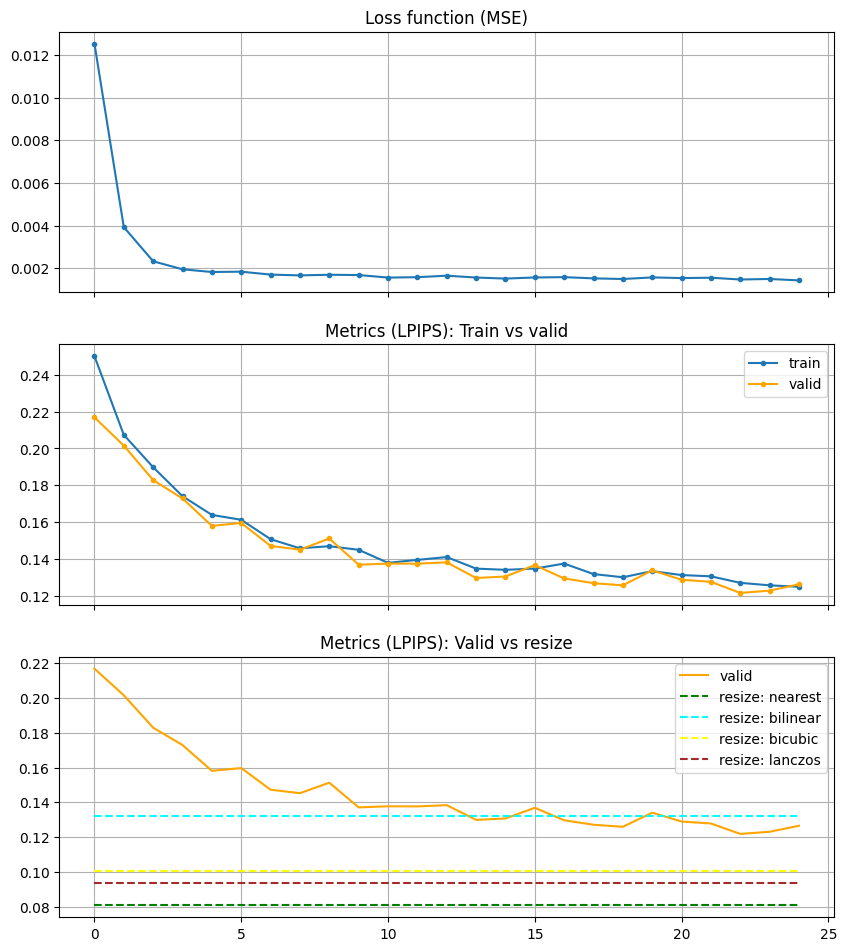

In [ ]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 11.5))
axs[0].plot(history, marker=".")
axs[0].grid()
axs[0].set_title("Loss function (MSE)")

axs[1].plot(metrics, marker=".", label='train')
axs[1].plot(valid_metrics, c="orange", marker=".", label='valid')

axs[1].legend()
axs[1].grid()
axs[1].set_title("Metrics (LPIPS): Train vs valid")

axs[2].plot(valid_metrics, c="orange", label='valid')
axs[2].plot([np.array(metric_nearest).mean()] * len(valid_metrics), linestyle='--', color='green', label='resize: nearest')
axs[2].plot([np.array(metric_bilinear).mean()] * len(valid_metrics), linestyle='--', color='cyan', label='resize: bilinear')
axs[2].plot([np.array(metric_bicubic).mean()] * len(valid_metrics), linestyle='--', color='yellow', label='resize: bicubic')
axs[2].plot([np.array(metric_lanczos).mean()] * len(valid_metrics), linestyle='--', color='brown', label='resize: lanczos')

axs[2].legend()
axs[2].grid()
axs[2].set_title("Metrics (LPIPS): Valid vs resize")

In [ ]:
input = valid_dataset[0][0]
output_real = valid_dataset[0][1]
output_model = model(input[None, :].to(device))[0]

print(input.shape)
print(output_real.shape)
print(output_model.shape)

torch.Size([3, 320, 320])
torch.Size([3, 640, 640])
torch.Size([3, 640, 640])


In [ ]:
input_image = Image.fromarray(np.uint8(input.transpose(0, 1).transpose(1, 2)))

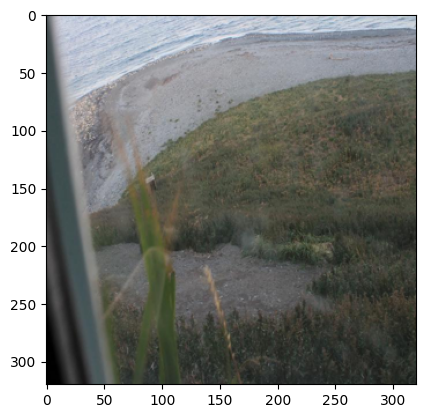

In [ ]:
plt.imshow(input_image)

In [ ]:
input_image.save("input_image.png")

In [ ]:
real_image = Image.fromarray(np.uint8(output_real.transpose(0, 1).transpose(1, 2)))

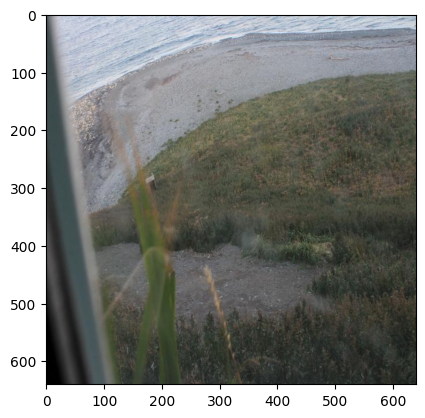

In [ ]:
plt.imshow(real_image)

In [ ]:
real_image.save("real_image.png")

In [ ]:
model_image = Image.fromarray(np.uint8(output_model.cpu().detach().transpose(0, 1).transpose(1, 2) * 255))

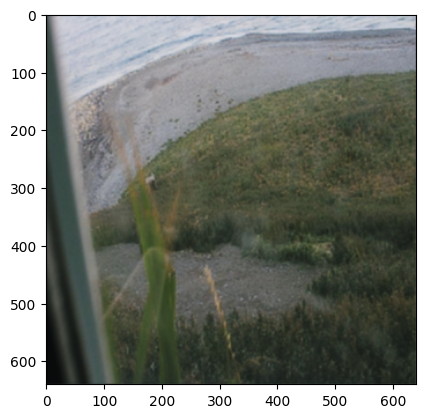

In [ ]:
plt.imshow(model_image)

In [ ]:
model_image.save("model_image.png")

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 72.2MB/s]


tensor(0.7708, grad_fn=<SqueezeBackward0>)